In [1]:
import gym
import highway_env
from matplotlib import pyplot as plt
%matplotlib inline


"""for _ in range(3):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, truncated, info = env.step(action)
    env.metadata['render_fps'] = 14
    env.render()

plt.imshow(env.render(mode="rgb_array"))
plt.show()"""

'for _ in range(3):\n    action = env.action_type.actions_indexes["IDLE"]\n    obs, reward, done, truncated, info = env.step(action)\n    env.metadata[\'render_fps\'] = 14\n    env.render()\n\nplt.imshow(env.render(mode="rgb_array"))\nplt.show()'

In [2]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3 import SAC
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [5]:
# Create log dir
log_dir1 = "/tmp/gym/"
os.makedirs(log_dir1, exist_ok=True)

env1 = gym.make('highway-v0')

# Logs will be saved in log_dir/monitor.csv
env1 = Monitor(env1, log_dir1)

env1.configure({"controlled_vehicles": 2})  # Two controlled vehicles
env1.configure({"vehicles_count": 5})  # A single other vehicle, for the sake of visualisation
env1.configure({"collision_reward": 0.6}) 
env1.reset(seed=0)
env1.reset()

/home/rohit/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


(array([[ 1.        ,  0.8919273 ,  0.75      ,  0.3125    ,  0.        ],
        [ 1.        ,  0.11146577, -0.75      , -0.04290927,  0.        ],
        [ 1.        ,  0.21280849, -0.5       , -0.01288804,  0.        ],
        [ 1.        ,  0.30696166,  0.        , -0.03807787,  0.        ],
        [ 1.        ,  0.5119154 , -0.25      ,  0.        ,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 1,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 1.0,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [6]:
import pprint

pprint.pprint(env1.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': 0.6,
 'controlled_vehicles': 2,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 5,
 'vehicles_density': 1}


In [7]:
from stable_baselines3 import DQN

callback1 = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir1)

model1 = DQN('MlpPolicy', env1,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/")
model1.learn(int(2e4), callback=callback1)
model1.save("highway_dqn/model1")

model1 = DQN.load("highway_dqn/model1", env=env1)

Using cpu device
Wrapping the env in a DummyVecEnv.


2022-12-12 14:40:58.065707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 14:40:59.136101: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Logging to highway_dqn/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.5      |
|    ep_rew_mean      | 28.1     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 14       |
|    total_timesteps  | 34       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.4     |
|    ep_rew_mean      | 40.5     |
|    exploration_rate | 0.953    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4        |
|    time_elapsed     | 20       |
|    total_timesteps  | 99       |
----------------------------------
Num timesteps: 100
Best mean reward: -inf - Last mean reward per episode: 40.51
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 200
Best mean reward: 40.51 - Last mean reward per episod

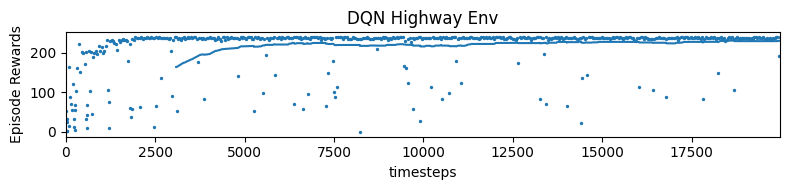

In [8]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir1], 1e5, results_plotter.X_TIMESTEPS, "DQN Highway Env")

In [9]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

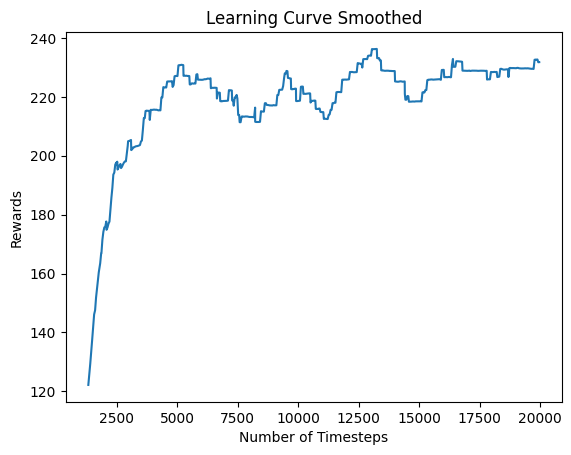

In [10]:
plot_results(log_dir1)

In [36]:
env2 = gym.make('highway-v0')

env2.configure({"controlled_vehicles": 5})  # Two controlled vehicles
env2.configure({"vehicles_count": 0})  # A single other vehicle, for the sake of visualisation
env2.configure({"collision_reward": 1}) 
env2.reset(seed=0)
env2.reset()

/home/rohit/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


(array([[ 1.        ,  0.9028463 ,  0.25      ,  0.3125    ,  0.        ],
        [ 1.        ,  0.20898543, -0.25      ,  0.        ,  0.        ],
        [ 1.        ,  0.4309162 ,  0.25      ,  0.        ,  0.        ],
        [ 1.        ,  0.6347424 ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.8557819 ,  0.        ,  0.        ,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 4,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 0.3333333333333333,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [ ]:
model2 = DQN('MlpPolicy', env2,
              policy_kwargs=dict(net_arch=[256, 256]),
              learning_rate=5e-4,
              buffer_size=15000,
              learning_starts=200,
              batch_size=32,
              gamma=0.8,
              train_freq=1,
              gradient_steps=1,
              target_update_interval=50,
              verbose=1,
              tensorboard_log="highway_dqn/")
model2.learn(int(2e4))
model2.save("highway_dqn/model2")

model2 = DQN.load("highway_dqn/model2", env=env2)

In [43]:

env3 = gym.make('highway-v0')

env3.configure({"controlled_vehicles": 2})  # Two controlled vehicles
env3.configure({"vehicles_count": 4})  # A single other vehicle, for the sake of visualisation
env3.configure({"collision_reward": 0.5}) 
env3.configure({

  "observation": {
    "type": "MultiAgentObservation",
    "observation_config": {
      "type": "Kinematics",
    }
  },
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})
env3.reset()

"""
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.imshow(env2.render(mode="rgb_array"))
ax1.set_title("Initial state")

# Make the first vehicle change to the left lane, and the second one to the right
action_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL
env2.step((action_1, action_2))

ax2.imshow(env2.render(mode="rgb_array"))
ax2.set_title("After sending actions to each vehicle")
plt.show()"""

/home/rohit/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


'\n_, (ax1, ax2) = plt.subplots(nrows=2)\nax1.imshow(env2.render(mode="rgb_array"))\nax1.set_title("Initial state")\n\n# Make the first vehicle change to the left lane, and the second one to the right\naction_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL\nenv2.step((action_1, action_2))\n\nax2.imshow(env2.render(mode="rgb_array"))\nax2.set_title("After sending actions to each vehicle")\nplt.show()'

In [5]:
from stable_baselines3 import DQN

model1 = DQN.load("highway_dqn/model1",env=env1)
model2 = DQN.load("highway_dqn/model2",env=env2)
while True:
  vec_env1=model1.get_env()
  done = truncated = False
  obs1 = vec_env1.reset()

  vec_env2=model2.get_env()
  done = truncated = False
  obs2 = vec_env2.reset()

  #print(info)
  while not (done or truncated):
    action1, _states1 = model1.predict(obs1, deterministic=True)
    action2, _states2 = model2.predict(obs2, deterministic=True)

    env3.metadata['render_fps'] = 14
    env3.step((action1[0], action2[0]))
    env3.render()


    
    """_, (ax1, ax2) = plt.subplots(nrows=2)
    ax1.imshow(env3.render(mode="rgb_array"))
    ax1.set_title("Initial state")
    print(action1,action2)
    # Make the first vehicle change to the left lane, and the second one to the right
    #action_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL
    env3.step((action1[0], action2[0]))

    ax2.imshow(env3.render(mode="rgb_array"))
    ax2.set_title("After sending actions to each vehicle")
    plt.show()"""

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/rohit/.local/lib/python3.10/site-packages/highway_env/utils.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return y[0] + (v - x[0]) * (y[1] - y[0]) / (x[1] - x[0])
/home/rohit/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:259: UserWarning: WARN: The reward is an inf value.
  logger.warn("The reward is an inf value.")
/home/rohit/.local/lib/python3.10/site-packages/highway_env/utils.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return y[0] + (v - x[0]) * (y[1] - y[0]) / (x[1] - x[0])
/home/rohit/.local/lib/python3.10/site-packages/highway_env/utils.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return y[0] + (v - x[0]) * (y[1] - y[0]) / (x[1] - x[0])
/home/rohit/.local/lib/python3.10/site-packages/highway_env/utils.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  return y[0] + (v - x[0]) * (y[1] - y[0]) / (x[1] - x[0])
/home/rohit/.local/lib/python3.10/site-packages/hi

KeyboardInterrupt: 

In [47]:
from stable_baselines3 import DQN

model1 = DQN.load("highway_dqn/model1",env=env1)
model2 = DQN.load("highway_dqn/model2",env=env2)
while True:
  vec_env1=model1.get_env()
  done = truncated = False
  obs1 = vec_env1.reset()

  vec_env2=model2.get_env()
  done = truncated = False
  obs2 = vec_env2.reset()

  vec_env3=model1.get_env()
  done = truncated = False
  obs3 = vec_env3.reset()


  #print(info)
  while not (done or truncated):
    action1, _states1 = model1.predict(obs1, deterministic=True)
    action2, _states2 = model2.predict(obs2, deterministic=True)

    action = tuple(model1.predict(obs1, deterministic=True))
    obs1, reward1, done1, info1= vec_env1.step(action1)
    obs2, reward2, done2, info2 = vec_env2.step(action2)
    vec_env3.metadata['render_fps'] = 14
    vec_env1.step((action1[0], action2[0]))
    #vec_env3.render()
    #vec_env1.render()
    vec_env1.render()


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


KeyboardInterrupt: 

In [48]:
import gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

In [49]:
mean_reward, std_reward = evaluate_policy(model1, model1.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:37.89 +/- 1.17


In [68]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3 import SAC
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [54]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [56]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env4 = gym.make('highway-v0')
# Logs will be saved in log_dir/monitor.csv
env4 = Monitor(env4, log_dir)



/home/rohit/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [69]:
# Create action noise because TD3 and DDPG use a deterministic policy
#n_actions = env4.action_space.shape[]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model4 = A2C('MlpPolicy', env4 , verbose=0)
# Train the agent
model4.learn(total_timesteps=int(5e4), callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 14.25
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: 14.25 - Last mean reward per episode: 18.32
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 3000
Best mean reward: 18.32 - Last mean reward per episode: 20.95
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 4000
Best mean reward: 20.95 - Last mean reward per episode: 25.17
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: 25.17 - Last mean reward per episode: 27.26
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 6000
Best mean reward: 27.26 - Last mean reward per episode: 27.65
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 7000
Best mean reward: 27.65 - Last mean reward per episode: 25.25
Num timesteps: 8000
Best mean reward: 27.65 - Last mean reward per episode: 14.51
Num timesteps: 9000
Best mean reward: 27.65 - Last 

In [ ]:
from stable_baselines3 import DQN

model1 = DQN.load("highway_dqn/model1",env=env1)
model2 = DQN.load("highway_dqn/model2",env=env2)
while True:
  vec_env1=model1.get_env()
  done = truncated = False
  obs1 = vec_env1.reset()

  vec_env2=model2.get_env()
  done = truncated = False
  obs2 = vec_env2.reset()

  vec_env3=model1.get_env()
  done = truncated = False
  obs3 = vec_env3.reset()


  #print(info)
  while not (done or truncated):
    action1, _states1 = model1.predict(obs1, deterministic=True)
    action2, _states2 = model2.predict(obs2, deterministic=True)

    action = tuple(model1.predict(obs1, deterministic=True))
    obs1, reward1, done1, info1= vec_env1.step(action1)
    obs2, reward2, done2, info2 = vec_env2.step(action2)
    vec_env3.metadata['render_fps'] = 14
    vec_env3.step((action1[0], action2[0]))
    #vec_env3.render()
    #vec_env1.render()
    vec_env3.render()

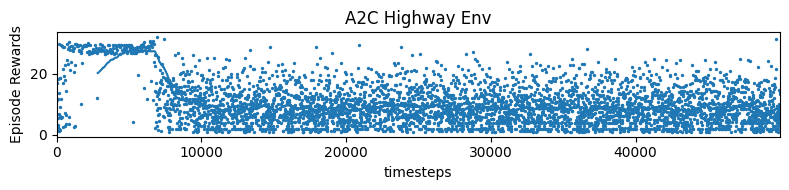

In [72]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "A2C Highway Env")

In [73]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

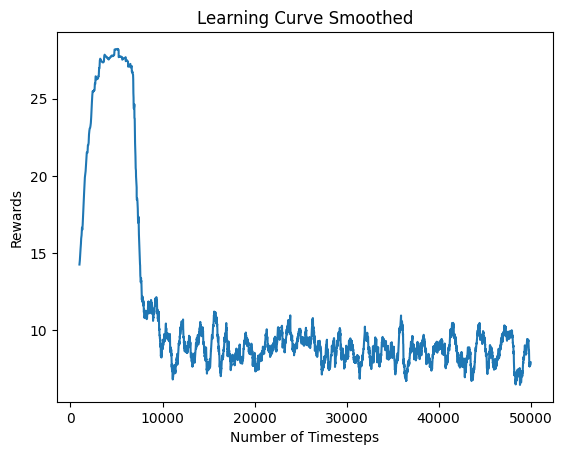

In [74]:
plot_results(log_dir)